<a href="https://colab.research.google.com/github/hyerymlim/NERModel_WusinsaReview/blob/main/WusinsaReview_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
f = open('tagging_complete.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0]
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

print(tagged_sentences)
print("전체 문장 개수: ", len(tagged_sentences))

[[['무난', 'B-DES'], ['해서', 'I-DES'], ['좋았던', 'I-DES'], ['같아요', 'O'], ['뭔가', 'O'], ['디테', 'B-DES'], ['일이', 'I-DES'], ['튈', 'I-DES'], ['라고', 'O'], ['해서', 'O'], ['걱정', 'O']], [['사진', 'O'], ['보이는', 'O'], ['색상', 'B-COL'], ['처럼', 'O'], ['괜찮은', 'O'], ['독특한', 'O'], ['블루', 'B-COL'], ['색', 'I-COL'], ['기모', 'B-MTR'], ['쨩쨩해', 'I-MTR'], ['서', 'O'], ['춥진', 'B-TMP'], ['않을듯', 'O'], ['합니다', 'O'], ['티셔츠', 'B-COD'], ['받쳐', 'I-COD'], ['입으려면', 'O'], ['노기로', 'O'], ['좋을', 'O'], ['듯', 'O']], [['재질', 'B-MTR'], ['좋고', 'B-SAT'], ['촉감', 'B-MTR'], ['좋습니다', 'B-SAT'], ['배송', 'B-DLV'], ['역시', 'O'], ['빠르고', 'B-DLV'], ['파세요', 'O']], [['교복', 'B-COD'], ['입기', 'I-COD'], ['정말', 'O'], ['무난', 'B-DES'], ['후드', 'O'], ['집업', 'O'], ['사이즈', 'B-SIZ'], ['넉넉하니', 'I-SIZ'], ['귀여워요', 'O']], [['얇은', 'B-MTR'], ['느낌이긴', 'O'], ['여름', 'B-TMP'], ['입기', 'O'], ['좋은', 'O'], ['같아요', 'O']], [['슬리퍼', 'O'], ['이렇게', 'O'], ['예뻐도', 'B-SAT'], ['돼', 'O'], ['만', 'O'], ['신고', 'O'], ['싶다', 'O'], ['예뻐요', 'B-SAT']], [['사이즈', 'B-SIZ'], ['적당하고', 'O'], ['따뜻합니다',

In [ ]:
tagged_sentences[375][14] = ['x', 'O'] # 불용어 처리시 정제되지 못한 이모티콘을 의미 없는 값으로 바꿔줌.

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 문장들을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 문장의 단어들은 sentence에, 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 문장에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 문장에서 개체명 태깅 정보만 저장한다.

print('첫번째 문장 :',sentences[0])
print('첫번째 문장의 태그 :',ner_tags[0])
print(len(sentences))
print(len(ner_tags))

첫번째 문장 : ['무난', '해서', '좋았던', '같아요', '뭔가', '디테', '일이', '튈', '라고', '해서', '걱정']
첫번째 문장의 태그 : ['B-DES', 'I-DES', 'I-DES', 'O', 'O', 'B-DES', 'I-DES', 'I-DES', 'O', 'O', 'O']
1578
1578


In [ ]:
all_tags_list = sum(ner_tags, [])
tags_len = Counter(all_tags_list)
print(tags_len)

Counter({'O': 10224, 'B-SIZ': 1405, 'B-SAT': 1310, 'I-SIZ': 721, 'B-MTR': 458, 'B-TMP': 384, 'B-COW': 342, 'B-COL': 337, 'B-DES': 320, 'I-SAT': 250, 'I-MTR': 189, 'B-COD': 176, 'I-COD': 169, 'I-DES': 165, 'I-COL': 151, 'I-COW': 143, 'B-QLT': 138, 'B-PRC': 131, 'B-WGT': 94, 'I-QLT': 85, 'B-DLV': 70, 'I-PRC': 67, 'I-DLV': 65, 'I-TMP': 54, 'B-MNG': 46, 'I-MNG': 23, 'I-WGT': 23, '': 23})


리뷰 데이터 최대 길이 : 82
리뷰 데이터 평균 길이 : 11.129911


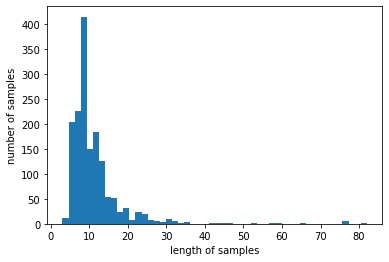

In [ ]:
print('리뷰 데이터 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('리뷰 데이터 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 3816
개체명 태깅 정보 집합의 크기 : 29


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print('첫번째 문장 :',X_data[0])
print('첫번째 문장의 레이블 :',y_data[0])

첫번째 문장 : [23, 41, 1741, 4, 312, 884, 1169, 1742, 460, 41, 103]
첫번째 문장의 레이블 : [9, 14, 14, 1, 1, 9, 14, 14, 1, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'o', 2: 'b-siz', 3: 'b-sat', 4: 'i-siz', 5: 'b-mtr', 6: 'b-tmp', 7: 'b-cow', 8: 'b-col', 9: 'b-des', 10: 'i-sat', 11: 'i-mtr', 12: 'b-cod', 13: 'i-cod', 14: 'i-des', 15: 'i-col', 16: 'i-cow', 17: 'b-qlt', 18: 'b-prc', 19: 'b-wgt', 20: 'i-qlt', 21: 'b-dlv', 22: 'i-prc', 23: 'i-dlv', 24: 'i-tmp', 25: 'b-mng', 26: 'i-mng', 27: 'i-wgt', 28: '', 0: 'PAD'}


In [ ]:
X_data = pad_sequences(X_data, padding='post')
y_data = pad_sequences(y_data, padding='post')

X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.1, random_state=1000)
# 검증용 데이터로 10%만 추출

y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

print('학습 문장 데이터의 크기 : {}'.format(X_train.shape))
print('학습 태그 데이터(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('학습 태그 데이터(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('검증 문장 데이터의 크기 : {}'.format(X_test.shape))
print('검증 태그 데이터(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('검증 태그 데이터(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

학습 문장 데이터의 크기 : (1420, 82)
학습 태그 데이터(정수 인코딩)의 크기 : (1420, 82)
학습 태그 데이터(원-핫 인코딩)의 크기 : (1420, 82, 29)
검증 문장 데이터의 크기 : (158, 82)
검증 태그 데이터(정수 인코딩)의 크기 : (158, 82)
검증 태그 데이터(원-핫 인코딩)의 크기 : (158, 82, 29)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.00001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
10/10 [==============================] - 28s 2s/step - loss: 0.4550 - accuracy: 0.0369 - val_loss: 0.4726 - val_accuracy: 0.0532
Epoch 2/50
10/10 [==============================] - 15s 2s/step - loss: 0.4548 - accuracy: 0.0658 - val_loss: 0.4724 - val_accuracy: 0.0924
Epoch 3/50
10/10 [==============================] - 15s 1s/step - loss: 0.4546 - accuracy: 0.1120 - val_loss: 0.4721 - val_accuracy: 0.1505
Epoch 4/50
10/10 [==============================] - 15s 2s/step - loss: 0.4544 - accuracy: 0.1808 - val_loss: 0.4719 - val_accuracy: 0.2318
Epoch 5/50
10/10 [==============================] - 15s 2s/step - loss: 0.4542 - accuracy: 0.2628 - val_loss: 0.4717 - val_accuracy: 0.3076
Epoch 6/50
10/10 [==============================] - 15s 2s/step - loss: 0.4539 - accuracy: 0.3494 - val_loss: 0.4714 - val_accuracy: 0.3878
Epoch 7/50
10/10 [==============================] - 16s 2s/step - loss: 0.4537 - accuracy: 0.4222 - val_loss: 0.4711 - val_accuracy: 0.4502
Epoch 8/50
10/10 [==

In [ ]:
i = 56 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
무신               : o       o
사                : o       o
스탠더드             : o       o
갈아탔어요            : o       o
마음               : b-sat   o
들어서              : i-sat   o
자주               : o       o
입고               : o       o
있어요              : o       o
